# Final Project w261


# Notebook Set-Up
Basic imports

In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import copy
import pprint

In [2]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "final_project"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]
PWD

'/media/notebooks/F18-2-kathleenyw/Assignments/FinalProject'

In [4]:
# # # create a data directory (RUN THIS CELL AS IS)
# # !mkdir data
# # # download the test data set (RUN THIS CELL AS IS)
# # this is to get txt files directly
# # !wget -q -O data/full_data.txt https://s3-eu-west-1.amazonaws.com/kaggle-display-advertising-challenge-dataset/
# # this is to get zip file
# !curl -L -o data/full_data.tar.gz https://s3-eu-west-1.amazonaws.com/kaggle-display-advertising-challenge-dataset/dac.tar.gz

In [5]:
# !tar xvzf data/full_data.tar.gz

In [6]:
%reload_ext autoreload
%autoreload 2

# Algorithm Comparison

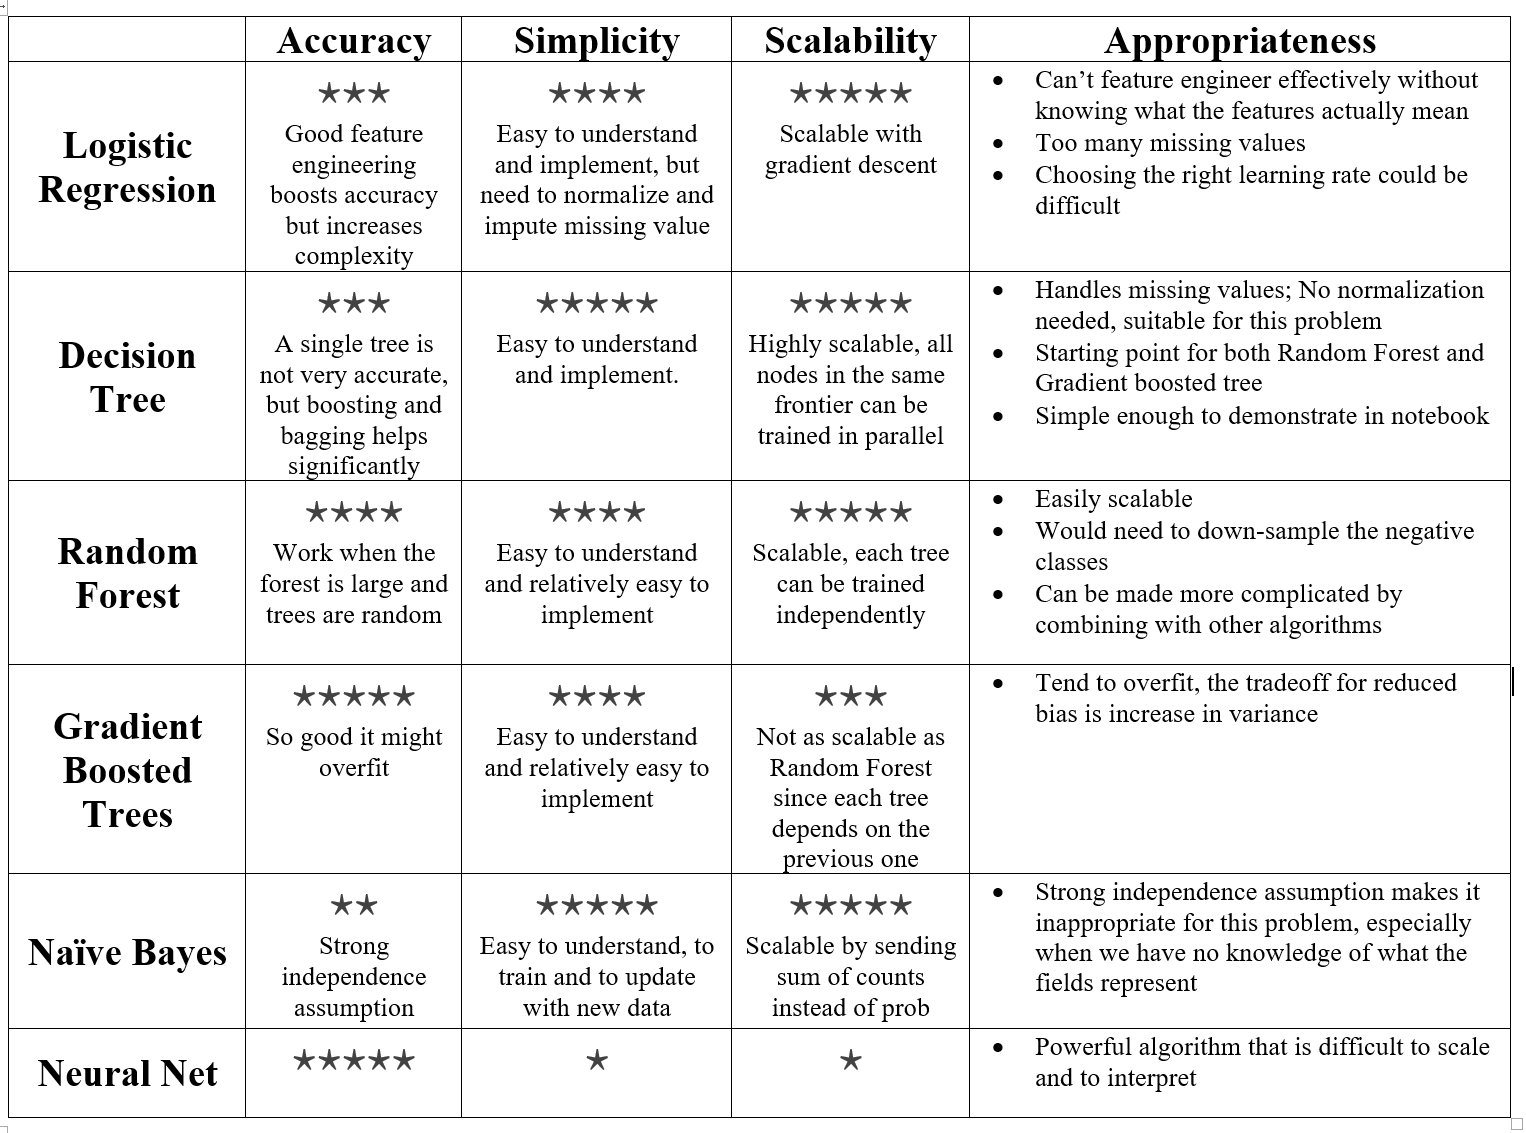

In [7]:
from IPython.display import Image
Image(filename="Model Comparison.PNG")

Since decision trees are easy to understand, simple to demonstrate and serves at the basis for two other powerful algorithms, we will demonstrate the basic of decision trees in the following section

# Decision Trees

#### **This section contains a simplified version that helps to demonstrate the concept of a tree. For a more complete and effective home-grown implementation of decision trees, please see the section on home-grown trees. Final models are boosted and/or bagged trees in MLIB**

## Step1: Create a toy dataset using values from the actual dataset
1. Actual dataset has plenty of null values, can treat nulls as a seperate category
2. Actual dataset has a large number of distinct values in some fields. As a result the parameter space is huge. Hashing trick needed
3. Column 3 & 4 uses values from the first two categorical columns in data
4. Rebalanced dataset. Original data has disporportional number of negative classes which would make algorithms inaccurate
5. Numerical fields treated as categories for simplicity for this toy demonstration

In [8]:
%%writefile toy_test.txt
1	1	2	68fd1e64	4631e0ab2
1	1	2	68fd1e64	4631e0ab2
1	1	2	68fd1e64	4631e0ab2
1	2	2	68fd1e64	4631e0ab2
1	2	2	68fd1e64	4631e0ab2
1	2	2	68fd1e64	510b40a51
1	2	2	8cf07265	510b40a51
1	3	2	8cf07265	510b40a51
1	3	2	8cf07265	510b40a51
0	1	2	68fd1e64	510b40a51
0	1	2	68fd1e64	510b40a51
0	1	2	68fd1e64	510b40a51
0	1	2	8cf07265	510b40a51
0	2	2	8cf07265	510b40a51
0	2	2	8cf07265	510b40a51
0	2	2	8cf07265	4631e0ab2
0	3	2	8cf07265	4631e0ab2
0	3	2	8cf07265	4631e0ab2
0	3	1	8cf07265	4631e0ab2
0	3	1	8cf07265	4631e0ab2

Overwriting toy_test.txt


In [9]:
toyRDD = sc.textFile("toy_test.txt") 

__`REMINDER`__: If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

## Step2: Check distinct field values, i.e. possible split points
The following jobs can be run on the actual data on clusters to count how many distinct values and missing values there are for each column.
The next job returns a list of the distinct values to be used as possible split points

#### One-hot encoding & Sparse Matrix:
Actual data has large number of rare occuring features. Creating one-hot encoding for all those features could be a nightmare for the 40mil rows
Instead, we maintain the data format but use each unique field value as a seperate category, similar to the stripe method. This significantly saves space and run time.

The possible split points looks like '1 3', which stands for field value "3" from original field "1". Again all numerical fields are treated as categories.

In [10]:
# This counts the number of unique values in each field as well as the total number of nulls
def col_no_and_val (row):
    for column, value in enumerate(row[1:]):
        yield ((column, value), 1)

def seperate_null (row):
    """since the values are now unique, can remove the actual value and just emit 1
    and emit another record if the value is null"""
    yield (row[0][0], 1)
    if row[0][1] == '':
        yield row

def convert_format (x):
    if type(x[0])==int:
        return (x[0], str(x[1])+' Distinct')
    else:
        return (x[0][0], str(x[1])+' Missing')

    
start = time.time()      
result= toyRDD.map(lambda row: row.split('\t')) \
                 .flatMap(col_no_and_val)\
                 .reduceByKey(lambda x,y : x+y)\
                 .flatMap(seperate_null)\
                 .reduceByKey(lambda x,y : x + y)\
                 .map(convert_format)\
                 .reduceByKey(lambda x,y : (x, y) if x[-1] == 'D' else (y, x))\
                 .sortBy(lambda x: x[0])\
                 .collect()
print(f'... completed job in {time.time() - start} seconds.')
result

... completed job in 2.6391289234161377 seconds.


[(0, '3 Distinct'), (1, '2 Distinct'), (2, '2 Distinct'), (3, '2 Distinct')]

In [11]:
# Here we create a list of all the possible splits
# For simplicity, we are treating all as categorical variables
# all null entries are replaced by the 'M'

def col_no_and_val (row):
    for column, value in enumerate(row[1:]):
        c = str(column+1)
        if value == '':
            v = 'M'
        else:
            v = str(value)
        
        v = str(column+1) +' ' + v        
        yield ('1', v)
        
start = time.time()      
result= toyRDD.map(lambda row: row.split('\t')) \
                 .flatMap(col_no_and_val)\
                 .distinct()\
                 .map(lambda x: ('1', {x[1]}))\
                 .reduceByKey(lambda x,y : x.union(y))\
                 .collect()
print(f'... completed job in {time.time() - start} seconds.')
split_points_org = list(result[0][1])
print("Total number of possible split points:")
print(len(split_points_org))
split_points_org

... completed job in 0.4113283157348633 seconds.
Total number of possible split points:
9


['1 3',
 '2 1',
 '4 510b40a51',
 '1 1',
 '2 2',
 '3 8cf07265',
 '3 68fd1e64',
 '4 4631e0ab2',
 '1 2']

## Step3: Build Binary Tree with Spark

### Step 3.1 Key Concepts


#### General Idea:
To build a tree, we need a iterative process that create binary splits at each node, choosing from a list of possible splits. 
After a split is chosen, we go down each path of the split and further split the data using this iterative process. We will stop when the termination criteria is met. 

#### Biase Variance Tradeoff
Given enough depth, our tree can fit the data perfectly by memorizing every data point. For the purpose of preventing overfitting, we can 1. stop growing tree after a few iterations 2. stop when there are < n data left in the branch 

#### Information Gain and Entropy:
Since this is a classification problem, one frequently used metric to choose a split among all possible splits is to look at the information gain if that split is chosen. Information gain is the reduction in entropy - a measure of uncertainty. For example, if  choosing a split results in 50% 0's and 50% 1's, we effectively gained no knowledge from this split, and hence the entropy is 1. 

$$
\text{Entropy:  }  
H(x) = -(p_1logp_1+p_2logp_2)
$$  

Information gain at each node means after applying one split at this node, how much more information did we get out of it. It is the difference between entropy at the root node $H_0$ and the weighted entropy at the left and right nodes  $p_1*H_1 + p_2*H_2$. When choosing among a list of possible splits, we are essentially selecting the split that gives us the minimum entropy


### Step 3.2 Tree building steps

#### 1. Design: Parallelize across data and across frontier:
Decision trees can easily be parallelized. The data can be processed seperately because we will only need the total counts in different categories. If we were to report on variance, we cannot calculate variances directly because it is not an **associative and commutative process**, changing the data order would change the result. To accurately report out variance, we will have to reduce the data to sums and counts and calculate the variance seperately.

Furthermore, as we go down the tree, we can build the entire frontier, i.e. each level of the tree in one interation since the data points should be cleanly seperated in each nodes in the same frontier. In other words, we can parallelize along each frontier when we build an entire tree layer in each iteration.
#### 2. Initilize and Broadcast:
In order to build tree, we need three pieces of information:
1. current tree structure
2. frontier: what nodes are we building in this iteration
3. split list: what are the possible splits
These three are small relative to the dataset and will be **broadcast** to all the clusters.  
After each iteration, all three must be updated and rebroadcasted with the new split information.

#### 3. Map record to counts:
For each record, decide which node the record is in. Then for each of the possible splits, decide if this record satisfies the split i.s. split=1, and also decide if the y value is 1, or both. These are the values needed for the entropy calculation

In [13]:
def map_each_record (x):
    ft = ft_bc.value
    sp = sp_bc.value
    t = t_bc.value
    
    level, node_numbers = ft
    
    cur_node = (1,1)

    if level != 1:
        for node in node_numbers:
            if eval(t[(level, node)][0] ):
                cur_node = (level,node)
        
    if cur_node == (1,1) and level == 1 or  cur_node != (1,1) :          
        for split in sp:
            """after identifying what node this is, compute counts for the given split"""
            col, val = split.split(' ')
            if x[int(col)] == val:
                split_count = 1
            else:
                split_count = 0
            
            y_val = int(x[0])
            if  x[int(col)] == val and x[0] =='1' :
                split1_y1 = 1
            else:
                split1_y1 = 0
            yield ((cur_node, split, split_count, y_val, split1_y1),1)    
    

#### 4. Sum up counts, calculate entropy:
From the mapped output, we can compute for each node_id + split_id key, the total counts associated with each possible split. With that, we can calculate weighted entropy for each possible split. More specifically: 

$$
H_{split1} = -(p_{y_1|split_1}logp_{y_1|split_1}+p_{y_0|split_1}logp_{y_0|split_1})\\ 
H_{split0} = -(p_{y_1|split_0}logp_{y_1|split_0}+p_{y_0|split_0}logp_{y_0|split_0}) \\
p_{y_1|split_1} = \frac{\text{count of y = 1 for those with split = 1}}{\text{count of those with split = 1}}\\
$$ 

Then we further reduce by selecting, for each node, the split that produces the minimum entropy. 

In [14]:
def reduce_and_sum (x,y):
    return (x[0]+y[0], x[1]+y[1], x[2]+y[2], x[3]+y[3])

def entropy(p1):
    """calculates the entropy given a probability"""
    p2 = 1-p1
    
    if p1 == 0 or p1 == 1:
        return 0
    else:
        return - (p1 * np.log2(p1) + p2 * np.log2(p2) )
def add_ce (x):
    """return  entropy of that split, plus the split1 count and split0 count
    (node_id, (split_point, ce, total in split1, total in split0, totaly1 in split1, totaly1 in split0)
     """
    totalsplit1cnt, totaly1cnt, totalsplit1y1cnt, totalcount = x[1]
    if totalsplit1cnt == 0 or totalsplit1cnt == totalcount:
        ce = 1
    else:
        p11 = float(totalsplit1y1cnt)/float(totalsplit1cnt)
        p01 =  float(totaly1cnt - totalsplit1y1cnt)/float(totalcount - totalsplit1cnt)
        prob_split = float(totalsplit1cnt)/float(totalcount)
        ce = prob_split * entropy(p11) + (1-prob_split)* entropy(p01)
    return (x[0][0], (x[0][1], ce, totalsplit1cnt, totalcount - totalsplit1cnt, totalsplit1y1cnt,totaly1cnt - totalsplit1y1cnt))

def min_ce (x, y):
    if x[1] > y[1]:
        return y
    else:
        return x
  

#### 5. Update tree structure, frontier and split list:
After finding the best splits for all the nodes in the frontier, we have to update the existing tree. We need information on the path to each node, its children, the value it split on and etc. There are efficient ways to achieve that, but for this demo we saved the entire path for each node so that we can easily read them.

#### 6. Stop growing tree if creteria are met
See earlier discussion on bias variance trade off. For demonstration, we stop after 3 iterations.

In [15]:
def update_tree_frontier (spark_result):
   
    def update_child (children, level, end):
        global next_frontier_cnt
        global next_frontier_nodes
        next_frontier_cnt += 1
        node_name = ((level+1), next_frontier_cnt)
        children.append(node_name)
        if end == False:
            next_frontier_nodes.append(next_frontier_cnt)
        return node_name        
    
    for each_node in spark_result:
        
        # read the spark result and get all the individual information needed to update tree
        node, values = each_node
        level, node_no = node
        split, ce, split1, split0, split1y1, split0y1 = values
        col, val = split.split(' ')
        
        priorpath = tree[node][0]

            
        # remove the split found from the big list
        split_points.remove(split)
        
        node_children = []
            
        # look at the left child, split = 1
        if priorpath == '':
            newpath = "x["+col+"] == '"+ val+"'"
        else:
            newpath = priorpath + "and x["+col+"] == '"+ val+"'"
        if split1 == 1 or split1y1 == split1 or split1y1 ==0:
            left_node = update_child (node_children, level, end=True)
            if split1y1 !=0:
                prediction = 1
            else:
                prediction = 0
                
            tree[left_node] =[newpath,'',[],str(prediction)]
        else:
            left_node =  update_child (node_children, level, end=False)
            tree[left_node] =[newpath,'',[],'']
         
        if priorpath == '':
            newpath = "x["+col+"] != '"+ val+"'"
        else:
            newpath = priorpath + "and x["+col+"] != '"+ val+"'"  
        if split0 == 1 or split0y1 == split0 or split0y1 ==0: 
            right_node = update_child (node_children, level, end=True)
            if split0y1 != 0:
                prediction = 1
            else:
                prediction = 0
            
            tree[right_node] =[newpath,'',[],str(prediction)]
        else:
            right_node =  update_child (node_children, level, end=False)
            tree[right_node] =[newpath,'',[],'']
    
        tree [node] =  [priorpath,split,node_children,'']
    
    global frontier
    frontier = [level+1, next_frontier_nodes]
    print('---------------output------------------')
    print('node_id | split_point   | entropy  | total in split1 | total in split0 | totaly1 in split1| totaly1 in split0')
    print("finished level", level,'\n')


### Run it through

In [16]:
## initialization

tree = {(1,1): ['','',[],'']}

frontier = [1,[1]]

split_points = copy.deepcopy(split_points_org)
start = time.time()   
for i in range(2):
    if frontier[1] == []:
        print ("finished building tree")
        print("total", i, "levels")
        break

    else:
        ft_bc = sc.broadcast(frontier)
        sp_bc = sc.broadcast(split_points)
        t_bc = sc.broadcast(tree)


        result= toyRDD.map(lambda row: row.split('\t')) \
                         .flatMap(map_each_record) \
                         .reduceByKey(lambda x,y : x + y)\
                         .map(lambda x: ((x[0][0], x[0][1]), (x[0][2]*x[1],x[0][3]*x[1],x[0][4]*x[1],x[1])))\
                         .reduceByKey(reduce_and_sum)\
                         .map(add_ce)\
                         .reduceByKey(min_ce)\
                         .collect()
        if result == []:
            print("did not find good split, terminate")
            break

        print(result)

        next_frontier_cnt = 0
        next_frontier_nodes = []
        update_tree_frontier(result)
        print("next frontier:", frontier)

print("------------Tree structure------------")
print("node_id | path_to_node  | split_point  | children    | predicted value|")

pprint.pprint(tree) 

print(f'... completed job in {time.time() - start} seconds.')



[((1, 1), ('3 8cf07265', 0.8781761404668604, 11, 9, 3, 6))]
---------------output------------------
node_id | split_point   | entropy  | total in split1 | total in split0 | totaly1 in split1| totaly1 in split0
finished level 1 

next frontier: [2, [1, 2]]
[((2, 2), ('4 4631e0ab2', 0.3605680553151701, 5, 4, 5, 1)), ((2, 1), ('4 510b40a51', 0.5454545454545454, 6, 5, 3, 0))]
---------------output------------------
node_id | split_point   | entropy  | total in split1 | total in split0 | totaly1 in split1| totaly1 in split0
finished level 2 

next frontier: [3, [2, 3]]
------------Tree structure------------
node_id | path_to_node  | split_point  | children    | predicted value|
{(1, 1): ['', '3 8cf07265', [(2, 1), (2, 2)], ''],
 (2, 1): ["x[3] == '8cf07265'", '4 510b40a51', [(3, 3), (3, 4)], ''],
 (2, 2): ["x[3] != '8cf07265'", '4 4631e0ab2', [(3, 1), (3, 2)], ''],
 (3, 1): ["x[3] != '8cf07265'and x[4] == '4631e0ab2'", '', [], '1'],
 (3, 2): ["x[3] != '8cf07265'and x[4] != '4631e0ab2'", '',

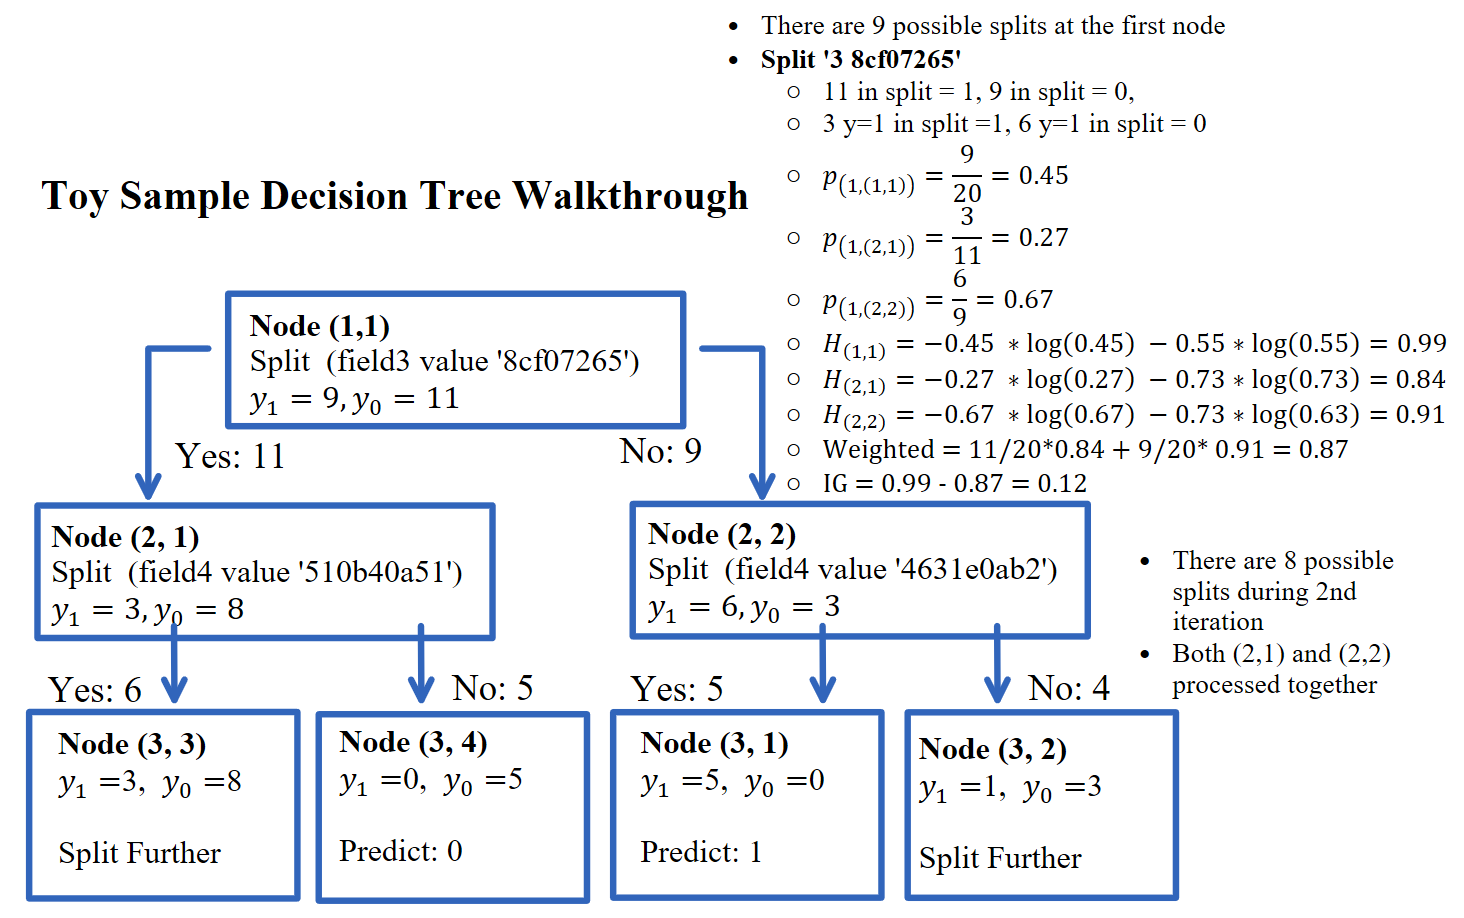

In [17]:
from IPython.display import Image
Image(filename="ToyTreeWalkThrough.PNG")

For the first node, after going through all 9 possible splits, we identified value '8cf07265' from field # 3 as the split point. Then for the next level, the left node (2,1) goes down the path where $x[3] == 8cf07265$ where as the right node (2,2) goes down the path there $x[3] != 8cf07265$

### Key Concepts mentioned in above sections:

1. bias variance tradeoff / model complexity / regularization (stopping criteria, random forest instead of gradient boost)
2. associative/commutative operations (variance not a/c, counts and sums are)
3. broadcasting / caching / DAGs / lazy evaluation (tree structures are broadcast in the spark job)
4. preserving the graph structure / additional payloads (tree structures are preserved, broadcast and updated)
5. One Hot Encoding / feature selection /sparse representation (hashing trick, discussed one-hot encode and sparse matrix)
6. normalization (one reason we choose trees)
